In [1]:
from astropy.constants import G
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
from astropy.time import Time
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from gala.units import galactic, UnitSystem
from twobody import TwoBodyKeplerElements, KeplerOrbit
from twobody.anomaly import mean_anomaly_from_eccentric_anomaly

usys = UnitSystem(1e12*u.Msun, u.kpc, u.Gyr, u.radian)

In [2]:
true_m31_sky_c = coord.SkyCoord(
    10.64628564*u.deg,
    41.23456631*u.deg
)

## Simulate some Keplerian data

In [3]:
M1 = 1.4e12 * u.Msun
M2 = 2.4e12 * u.Msun
M = M1 + M2
a = 511 * u.kpc
eta = 4.3 * u.rad
e = 0.981

In [4]:
mean_anomaly = mean_anomaly_from_eccentric_anomaly(eta, e)

In [5]:
elem = TwoBodyKeplerElements(
    a=a, m1=M1, m2=M2, e=e, 
    omega=0*u.rad, i=90*u.deg,
    M0=0.*u.rad, t0=0. * u.Gyr,
    units=galactic
)

In [6]:
orb1 = KeplerOrbit(elem.primary)
orb2 = KeplerOrbit(elem.secondary)
Romega = coord.matrix_utilities.rotation_matrix(elem.secondary.omega, 'z')

In [7]:
xyz1 = orb1.orbital_plane(0. * u.Gyr)
xyz2 = orb2.orbital_plane(0. * u.Gyr).transform(Romega)
xyz1, xyz2

(<CartesianRepresentation (x, y, z) in kpc
     (6.132, 0., 0.)
  (has differentials w.r.t.: 's')>,
 <CartesianRepresentation (x, y, z) in kpc
     (-3.577, -4.3805616e-16, 0.)
  (has differentials w.r.t.: 's')>)

In [8]:
time = (elem.P * (mean_anomaly / (2*np.pi*u.rad))).to(u.Gyr)
xyz1 = orb1.orbital_plane(time)
xyz2 = orb2.orbital_plane(time).transform(Romega)

(xyz1.without_differentials() 
 - xyz2.without_differentials()).norm().to(u.kpc)

<Quantity 711.91701777 kpc>

In [9]:
a * (1 - e * np.cos(eta))

<Quantity 711.91701777 kpc>

In [10]:
times = np.linspace(0, 1, 1024) * elem.P
xyzs1 = orb1.orbital_plane(times)
xyzs2 = orb2.orbital_plane(times).transform(Romega)

rs = (xyzs1.without_differentials() 
 - xyzs2.without_differentials()).norm().to(u.kpc)

(-1022.0, 1022.0)

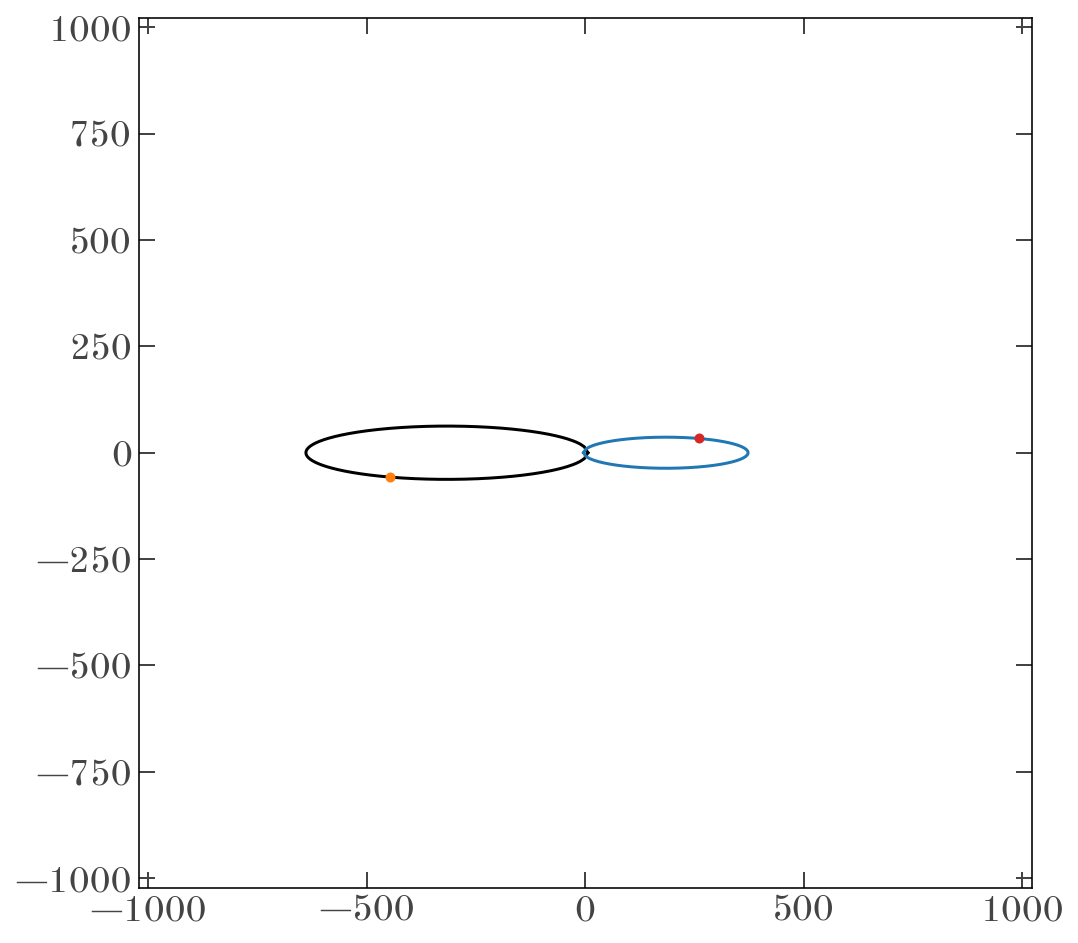

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(xyzs1.x, xyzs1.y, marker='')
ax.plot(xyzs2.x, xyzs2.y, marker='')

ax.plot(xyz1.x, xyz1.y, zorder=100, ms=10, color='tab:orange')
ax.plot(xyz2.x, xyz2.y, zorder=100, ms=10, color='tab:red')

ax.set_xlim(-2*a.value, 2*a.value)
ax.set_ylim(-2*a.value, 2*a.value)

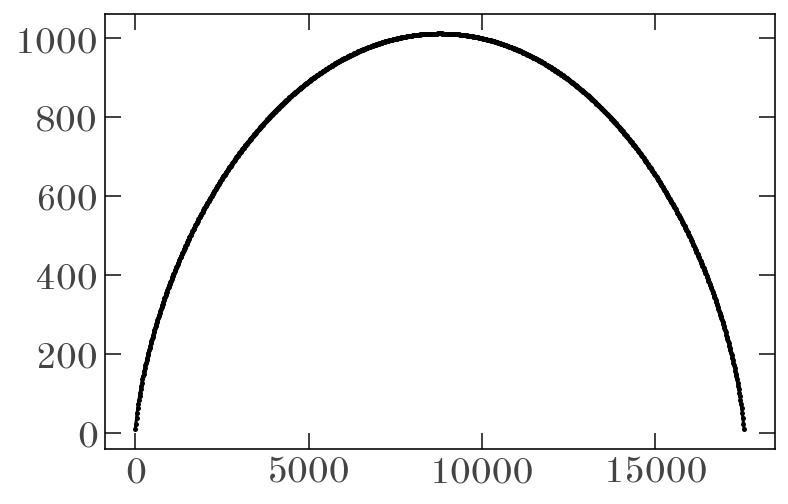

In [12]:
plt.plot(times.value, rs.value)

In [13]:
dxs = xyzs1.without_differentials() - xyzs2.without_differentials()
dvs = xyzs1.differentials['s'] - xyzs2.differentials['s']

dx_cyl = dxs.represent_as(coord.CylindricalRepresentation)
dv_cyl = dvs.represent_as(coord.CylindricalDifferential, dxs)

vrads = dv_cyl.d_rho
vtans = (dx_cyl.rho * dv_cyl.d_phi).to(u.km/u.s, u.dimensionless_angles())

In [14]:
etas = np.linspace(0, 2*np.pi, 1024) * u.rad
mean_anoms = mean_anomaly_from_eccentric_anomaly(etas, e)
eq_times = elem.P * (mean_anoms / (2*np.pi*u.rad))
eq_vrad = np.sqrt(G * M / a) * (e * np.sin(etas)) / (1 - e * np.cos(etas))
eq_vtan = np.sqrt(G * M / a) * np.sqrt(1 - e**2) / (1 - e * np.cos(etas))

(-500.0, 500.0)

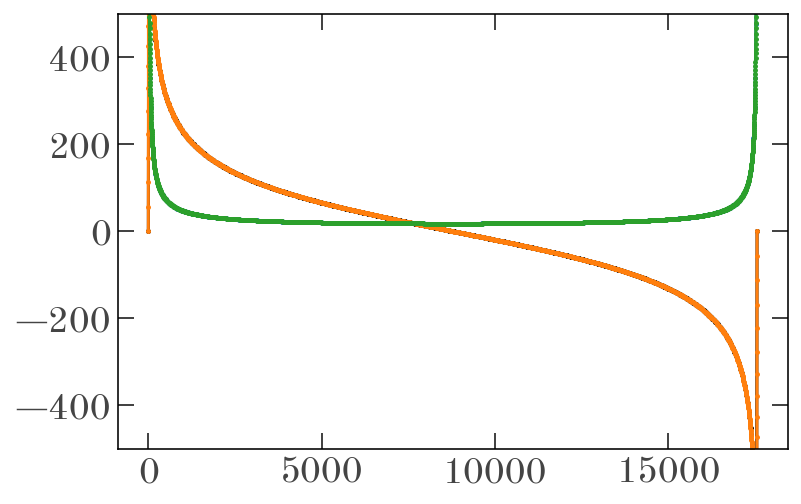

In [15]:
plt.plot(times.value, vrads.to_value(u.km/u.s))
plt.plot(times.value, vtans.to_value(u.km/u.s))

plt.plot(eq_times.value, eq_vrad.to_value(u.km/u.s))
plt.plot(eq_times.value, eq_vtan.to_value(u.km/u.s))

plt.ylim(-500, 500)

### Transform to ICRS

In [16]:
dx = xyz1.without_differentials() - xyz2.without_differentials()
dv = xyz1.differentials['s'] - xyz2.differentials['s']

dx_cyl = dx.represent_as(coord.CylindricalRepresentation)
dv_cyl = dv.represent_as(coord.CylindricalDifferential, dx)

vrad = dv_cyl.d_rho.to(u.km/u.s)
vtan = (dx_cyl.rho * dv_cyl.d_phi).to(u.km/u.s, u.dimensionless_angles())

r = dx.norm()

sun_galcen_dist = coord.Galactocentric().galcen_distance
gamma = coord.Galactocentric().galcen_coord.separation(true_m31_sky_c)
sun_m31_dist = (sun_galcen_dist * np.cos(gamma)) + np.sqrt(
    r**2 - sun_galcen_dist**2 * np.sin(gamma)**2
)

r, sun_m31_dist

(<Quantity 711.91701777 kpc>, <Quantity 707.97617293 kpc>)

In [17]:
vscale = np.sqrt(G * M / a)
print(vscale.decompose(usys).value, 
      vrad.decompose(usys).value, 
      vtan.decompose(usys).value)

182.90067763093654 -117.99130053868998 25.469820155258876


In [18]:
alpha = 32.4 * u.deg
galcen_pos = coord.SkyCoord(true_m31_sky_c.ra, 
                            true_m31_sky_c.dec, 
                            distance=sun_m31_dist)
galcen_pos = galcen_pos.transform_to(coord.Galactocentric())
# galcen_pos = coord.CartesianRepresentation(
#     -375 * u.kpc, 605 * u.kpc, -279 * u.kpc)
# galcen_pos = coord.Galactocentric(galcen_pos / galcen_pos.norm() * r)

galcen_sph = galcen_pos.represent_as('spherical')
gc_Rz = coord.matrix_utilities.rotation_matrix(-galcen_sph.lon, 'z')
gc_Ry = coord.matrix_utilities.rotation_matrix(galcen_sph.lat, 'y')
gc_Rx = coord.matrix_utilities.rotation_matrix(alpha, 'x')
R = gc_Rz @ gc_Ry @ gc_Rx

In [19]:
fake_X = R @ [r.value, 0, 0] * r.unit
fake_V = R @ [vrad.to_value(u.km/u.s), vtan.to_value(u.km/u.s), 0.] * u.km/u.s
fake_galcen = coord.Galactocentric(*fake_X, *fake_V)

In [20]:
fake_icrs = fake_galcen.transform_to(coord.ICRS())

In [21]:
fake_icrs

<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (10.64628564, 41.23456631, 707.97617293)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.04805931, -0.02682814, -301.90693118)>

## Check roundtripping

In [22]:
def tt_sph_to_xyz(r, lon, lat):
    return [
        r * np.cos(lon) * np.cos(lat),
        r * np.sin(lon) * np.cos(lat),
        r * np.sin(lat)
    ]

def tt_cross(a, b):
    return np.array([
        a[1]*b[2] - a[2]*b[1],
        a[2]*b[0] - a[0]*b[2],
        a[0]*b[1] - a[1]*b[0]
    ])

def tt_rotation_matrix(angle_rad, axis):
    s = np.sin(angle_rad)
    c = np.cos(angle_rad)
    
    if axis == 'x':
        R = np.array([
            1., 0, 0,
            0, c, s,
            0, -s, c
        ])
    
    elif axis == 'y':
        R = np.array([
            c, 0, -s,
            0, 1., 0,
            s, 0, c
        ])
        
    elif axis == 'z':
        R = np.array([
            c, s, 0,
            -s, c, 0,
            0, 0, 1.
        ])
        
    else:
        raise ValueError('bork')
        
    return np.reshape(R, (3, 3))

In [23]:
def ugh(m31_ra_rad, m31_dec_rad, m31_distance_kpc, r, vrad, vtan):
    galcen_frame = coord.Galactocentric()
    
    # tangent bases: ra, dec, r
    M = np.array([
        [-np.sin(m31_ra_rad), np.cos(m31_ra_rad), 0.],
        [-np.sin(m31_dec_rad)*np.cos(m31_ra_rad), -np.sin(m31_dec_rad)*np.sin(m31_ra_rad), np.cos(m31_dec_rad)],
        [np.cos(m31_dec_rad)*np.cos(m31_ra_rad), np.cos(m31_dec_rad)*np.sin(m31_ra_rad), np.sin(m31_dec_rad)]
    ])

    # Matrix to go from ICRS to Galactocentric
    R_I2G, offset_I2G = coord.builtin_frames.galactocentric.get_matrix_vectors(
        galcen_frame, inverse=False)
    dxyz_I2G = offset_I2G.xyz.to_value(usys['length'])
    dvxyz_I2G = offset_I2G.differentials['s'].d_xyz.to_value(usys['velocity'])

    # Matrix to go from Galactocentric to ICRS
    R_G2I, offset_G2I = coord.builtin_frames.galactocentric.get_matrix_vectors(
        galcen_frame, inverse=True)
    dxyz_G2I = offset_G2I.xyz.to_value(usys['length'])
    dvxyz_G2I = offset_G2I.differentials['s'].d_xyz.to_value(usys['velocity'])
    
    m31_icrs_xyz = tt_sph_to_xyz(m31_distance_kpc, 
                                 m31_ra_rad, m31_dec_rad)
    m31_galcen_xyz = np.dot(R_I2G, m31_icrs_xyz) + dxyz_I2G
    m31_galcen_lon = np.arctan2(m31_galcen_xyz[1], m31_galcen_xyz[0])
    m31_galcen_lat = np.arcsin(m31_galcen_xyz[2] / r)

    xhat = m31_galcen_xyz / r

    Rz = tt_rotation_matrix(-m31_galcen_lon, 'z')
    print(gc_Ry)
    Ry = tt_rotation_matrix(m31_galcen_lat, 'y')
    print(Ry)
    Rx = tt_rotation_matrix(alpha, 'x')
    yhat = np.dot(np.dot(Rz, np.dot(Ry, Rx)), [0, 1, 0.])
    zhat = tt_cross(xhat, yhat)
    R_LGtoG = np.stack((xhat, yhat, zhat), axis=1)
    print(R_LGtoG - R)

    x_LG = np.array([r, 0., 0.])
    v_LG = np.array([vrad, vtan, 0.])

    x_I = np.dot(R_G2I, np.dot(R_LGtoG, x_LG)) + dxyz_G2I
    v_I = np.dot(R_G2I, np.dot(R_LGtoG, v_LG)) + dvxyz_G2I
    v_I_tangent_plane = np.dot(M, v_I)  # alpha, delta, radial
    
    shit1 = coord.CartesianRepresentation(*((R @ x_LG) * usys['length']))
    shit2 = coord.CartesianDifferential(*((R @ v_LG) * usys['velocity']))
    shit = coord.SkyCoord(shit1.with_differentials(shit2), frame=coord.Galactocentric())
    
    return x_I, v_I, shit.transform_to(coord.ICRS()).velocity

In [24]:
ugh(fake_icrs.ra.radian, fake_icrs.dec.radian, fake_icrs.distance.to_value(u.kpc), 
    r.decompose(usys).value, vrad.decompose(usys).value, vtan.decompose(usys).value)

[[ 0.93103307  0.          0.36493481]
 [ 0.          1.          0.        ]
 [-0.36493481  0.          0.93103307]]
[[ 0.93103307  0.          0.36493481]
 [ 0.          1.          0.        ]
 [-0.36493481  0.          0.93103307]]
[[-5.55111512e-17 -1.11022302e-16  0.00000000e+00]
 [ 1.11022302e-16  1.11022302e-16 -5.89805982e-17]
 [ 1.11022302e-16  0.00000000e+00  1.11022302e-16]]


(array([523.24570605,  98.36033986, 466.65772905]),
 array([-199.02221943,  130.43392283, -272.7683983 ]),
 <CartesianDifferential (d_x, d_y, d_z) in km / s
     (-194.6023781, 127.53727518, -266.71081818)>)

In [25]:
fake_icrs.velocity

<CartesianDifferential (d_x, d_y, d_z) in km / s
    (-194.6023781, 127.53727518, -266.71081818)>

In [26]:
def ugh2():
    galcen_frame = coord.Galactocentric()

    # Matrix to go from ICRS to Galactocentric
    R_I2G, offset_I2G = coord.builtin_frames.galactocentric.get_matrix_vectors(
        galcen_frame, inverse=False)
    dxyz_I2G = offset_I2G.xyz.to_value(usys['length'])
    dvxyz_I2G = offset_I2G.differentials['s'].d_xyz.to_value(usys['velocity'])

    # Matrix to go from Galactocentric to ICRS
    R_G2I, offset_G2I = coord.builtin_frames.galactocentric.get_matrix_vectors(
        galcen_frame, inverse=True)
    dxyz_G2I = offset_G2I.xyz.to_value(usys['length'])
    dvxyz_G2I = offset_G2I.differentials['s'].d_xyz.to_value(usys['velocity'])
    
    m31_icrs_xyz = tt_sph_to_xyz(m31_distance_kpc, 
                                 m31_ra_rad, m31_dec_rad)
    m31_galcen_xyz = np.dot(R_I2G, m31_icrs_xyz) + dxyz_I2G
    m31_galcen_lon = np.arctan2(m31_galcen_xyz[1], m31_galcen_xyz[0])
    m31_galcen_lat = np.arcsin(m31_galcen_xyz[2] / r)

    xhat = m31_galcen_xyz / r

    Rz = tt_rotation_matrix(-m31_galcen_lon, 'z')
    Ry = tt_rotation_matrix(m31_galcen_lat, 'y')
    Rx = tt_rotation_matrix(alpha, 'x')
    yhat = np.dot(np.dot(Rz, np.dot(Ry, Rx)), [0, 1, 0.])
    zhat = tt_cross(xhat, yhat)
    R_LGtoG = np.stack((xhat, yhat, zhat), axis=1)

    x_LG = np.array([r, 0., 0.])
    v_LG = np.array([vrad, vtan, 0.])

    x_I = np.dot(R_G2I, np.dot(R_LGtoG, x_LG)) + dxyz_G2I
    v_I = np.dot(R_G2I, np.dot(R_LGtoG, v_LG)) + dvxyz_G2I
    v_I_tangent_plane = np.dot(M, v_I)  # alpha, delta, radial
    
    shit1 = coord.CartesianRepresentation(*((R @ x_LG) * usys['length']))
    shit2 = coord.CartesianDifferential(*((R @ v_LG) * usys['velocity']))
    shit = coord.SkyCoord(shit1.with_differentials(shit2), frame=coord.Galactocentric())
    
    return x_I, v_I, shit.transform_to(coord.ICRS()).velocity

## Write data to files:

In [27]:
rng = np.random.default_rng(seed=42)

dist_err = 11. * u.kpc
pmra_err = 3 * u.microarcsecond / u.yr
pmdec_err = 4 * u.microarcsecond / u.yr
rv_err = 2. * u.km/u.s
t_err = 0.11 * u.Gyr

tbl = {}
tbl['ra'] = u.Quantity(fake_icrs.ra)
tbl['dec'] = u.Quantity(fake_icrs.dec)

tbl['distance'] = rng.normal(fake_icrs.distance.to_value(u.kpc),
                             dist_err.to_value(u.kpc)) * u.kpc
tbl['distance_err'] = dist_err

tbl['pm_ra_cosdec'] = rng.normal(
    fake_icrs.pm_ra_cosdec.to_value(pmra_err.unit),
    pmra_err.value) * pmra_err.unit
tbl['pm_ra_cosdec_err'] = pmra_err

tbl['pm_dec'] = rng.normal(
    fake_icrs.pm_dec.to_value(pmdec_err.unit),
    pmdec_err.value) * pmdec_err.unit
tbl['pm_dec_err'] = pmdec_err

tbl['radial_velocity'] = rng.normal(
    fake_icrs.radial_velocity.to_value(rv_err.unit),
    rv_err.value) * rv_err.unit
tbl['radial_velocity_err'] = rv_err

tbl['tperi'] = rng.normal(
    time.to_value(t_err.unit),
    t_err.value) * t_err.unit
tbl['tperi_err'] = t_err

t = at.QTable({k: [] * tbl[k].unit for k in tbl})
t.add_row(tbl)

t.meta['title'] = 'Simulated Two-body'

t.write('../datasets/apw-simulated.ecsv', overwrite=True)

In [28]:
rng = np.random.default_rng(seed=42)

dist_err = 1. * u.kpc
pmra_err = 0.1 * u.microarcsecond / u.yr
pmdec_err = 0.1 * u.microarcsecond / u.yr
rv_err = 0.1 * u.km/u.s
t_err = 0.02 * u.Gyr

tbl = {}
tbl['ra'] = u.Quantity(fake_icrs.ra)
tbl['dec'] = u.Quantity(fake_icrs.dec)

tbl['distance'] = rng.normal(fake_icrs.distance.to_value(u.kpc),
                             dist_err.to_value(u.kpc)) * u.kpc
tbl['distance_err'] = dist_err

tbl['pm_ra_cosdec'] = rng.normal(
    fake_icrs.pm_ra_cosdec.to_value(pmra_err.unit),
    pmra_err.value) * pmra_err.unit
tbl['pm_ra_cosdec_err'] = pmra_err

tbl['pm_dec'] = rng.normal(
    fake_icrs.pm_dec.to_value(pmdec_err.unit),
    pmdec_err.value) * pmdec_err.unit
tbl['pm_dec_err'] = pmdec_err

tbl['radial_velocity'] = rng.normal(
    fake_icrs.radial_velocity.to_value(rv_err.unit),
    rv_err.value) * rv_err.unit
tbl['radial_velocity_err'] = rv_err

tbl['tperi'] = rng.normal(
    time.to_value(t_err.unit),
    t_err.value) * t_err.unit
tbl['tperi_err'] = t_err

t = at.QTable({k: [] * tbl[k].unit for k in tbl})
t.add_row(tbl)

t.meta['title'] = 'Simulated Two-body - precise'

t.write('../datasets/apw-simulated-precise.ecsv', overwrite=True)

In [29]:
rng = np.random.default_rng(42)

tbl = {}

vrad_err = 1 * u.km/u.s
vtan_err = 1 * u.km/u.s
t_err = 0.1 * u.Gyr
r_err = 1 * u.kpc

tbl['vrad'] = rng.normal(
    vrad.to_value(vrad_err.unit),
    vrad_err.value) * vrad_err.unit
tbl['vrad_err'] = vrad_err

tbl['vtan'] = rng.normal(
    vtan.to_value(vtan_err.unit),
    vtan_err.value) * vtan_err.unit
tbl['vtan_err'] = vtan_err

tbl['r'] = rng.normal(
    r.to_value(r_err.unit),
    r_err.value) * r_err.unit
tbl['r_err'] = r_err

tbl['tperi'] = rng.normal(
    time.to_value(t_err.unit),
    t_err.value) * t_err.unit
tbl['tperi_err'] = t_err

t = at.QTable({k: [] * tbl[k].unit for k in tbl})
t.add_row(tbl)

t.meta['title'] = 'Simulated Two-body - simple vrad, vtan'

t.write('../datasets/apw-simulated-simple.ecsv', overwrite=True)